---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the Jupyter Notebook FAQ course resource._

---

# Assignment 4 - Predicting and understanding viewer engagement with educational videos 

With the accelerating popularity of online educational experiences, the role of online lectures and other educational video continues to increase in scope and importance. Open access educational repositories such as <a href="http://videolectures.net/">videolectures.net</a>, as well as Massive Open Online Courses (MOOCs) on platforms like Coursera, have made access to many thousands of lectures and tutorials an accessible option for millions of people around the world. Yet this impressive volume of content has also led to a challenge in how to find, filter, and match these videos with learners. This assignment gives you an example of how machine learning can be used to address part of that challenge.

## About the prediction problem

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. For this assignment, your task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

We chose this prediction problem for several reasons:

* It combines a variety of features derived from a rich set of resources connected to the original data;
* The manageable dataset size means the dataset and supervised models for it can be easily explored on a wide variety of computing platforms;
* Predicting popularity or engagement for a media item, especially combined with understanding which features contribute to its success with viewers, is a fun problem but also a practical representative application of machine learning in a number of business and educational sectors.


## About the dataset

We extracted training and test datasets of educational video features from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. 

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single educational video, and includes information about diverse properties of the video content as described further below. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.

Note: Any extra variables that may be included in the training set are simply for your interest if you want an additional source of data for visualization, or to enable unsupervised and semi-supervised approaches. However, they are not included in the test set and thus cannot be used for prediction. **Only the data already included in your Coursera directory can be used for training the model for this assignment.**

For this final assignment, you will bring together what you've learned across all four weeks of this course, by exploring different prediction models for this new dataset. In addition, we encourage you to apply what you've learned about model selection to do hyperparameter tuning using training/validation splits of the training data, to optimize the model and further increase its performance. In addition to a basic evaluation of model accuracy, we've also provided a utility function to visualize which features are most and least contributing to the overall model performance.

**File descriptions** 
    assets/train.csv - the training set (Use only this data for training your model!)
    assets/test.csv - the test set
<br>

**Data fields**

train.csv & test.csv:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
train.csv only:
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.
    

## Evaluation

Your predictions will be given as the probability that the corresponding video will be engaging to learners.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model with an AUC (area under ROC curve) of at least 0.8 passes this assignment, and over 0.85 will receive full points.
___

For this assignment, create a function that trains a model to predict significant learner engagement with a video using `asset/train.csv`. Using this model, return a Pandas Series object of length 2309 with the data being the probability that each corresponding video from `readonly/test.csv` will be engaging (according to a model learned from the 'engagement' label in the training set), and the video index being in the `id` field.

Example:

    id
       9240    0.401958
       9241    0.105928
       9242    0.018572
                 ...
       9243    0.208567
       9244    0.818759
       9245    0.018528
             ...
       Name: engagement, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out and check your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. 

* Try to avoid global variables. If you have other functions besides engagement_model, you should move those functions inside the scope of engagement_model.

* Be sure to first check the pinned threads in Week 4's discussion forum if you run into a problem you can't figure out.

### Extensions

* If this prediction task motivates you to explore further, you can find more details here on the original VLE dataset and others related to video engagement: https://github.com/sahanbull/VLE-Dataset



In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   # Do not change this value: required to be compatible with solutions generated by the autograder.

In [2]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, mean_squared_error
from sklearn.metrics import roc_auc_score, r2_score, SCORERS
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier, Lasso, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from math import sqrt
from adspy_shared_utilities import plot_feature_importances

Scalers = [MinMaxScaler() ,MaxAbsScaler(), StandardScaler()]
DummyClass_Strategies = ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']
DummyClass_Strategies.pop()
LogReg_Solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
Ridge_Solver = ['lbfgs', 'cholesky', 'sparse_cg']
SVM_Kernels = ['linear','polynomial','rbf','sigmoid']
SCORERS = sorted(list(SCORERS.keys()))
SCORERS_subset = ['precision','recall','f1','roc_auc']

In [6]:
# Explore the data a bit
# Input data, both training/validation and test sets
trainval_df = pd.read_csv('assets/train.csv')
test_df = pd.read_csv('assets/test.csv')
# Break training/validation sets into targer and features
trainval_y = trainval_df['engagement']
trainval_X = trainval_df.loc[:, trainval_df.columns != 'engagement'].set_index('id')
features = list(trainval_X.columns)
X_test = test_df.set_index('id')
X_test_ids = X_test.index.tolist()
# Binarize the target values for the training and validation sets
trainval_y = trainval_y.astype(str)
trainval_y.replace(to_replace={'False':0,'True':1}, inplace=True)

# Create training and validation sets for both features and targets
X_train, X_val, y_train, y_val = train_test_split(trainval_X, trainval_y)

# Define the scaler, then fit to X_train and transform X_train, X_val, and X_test
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Tree Validation set AUC:  0.8526580503412106


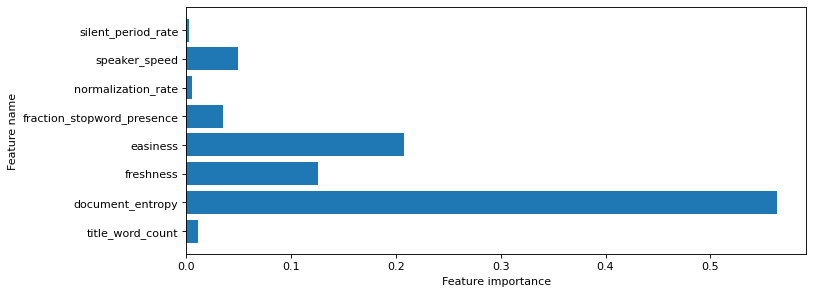

In [7]:
## Decision Tree Classifier
# tree = DecisionTreeClassifier().fit(X_train, y_train)
# print("Accuracy Score for Decision Tree on Training Data:",tree.score(X_train, y_train))
# print("Accuracy Score for Decision Tree on Validation Data:",tree.score(X_val, y_val))
## Decision Tree Classifier with GridSearchCV
tree = DecisionTreeClassifier()
grid_values = {'max_depth': [2, 3, 4, 5, 6]}
cv = 3
tree_grid = GridSearchCV(tree, param_grid=grid_values, scoring='roc_auc', cv=cv)
tree_grid.fit(X_train, y_train)
y_val_scores_tree_grid = tree_grid.predict_proba(X_val)
y_val_scores_tree_grid = y_val_scores_tree_grid[:,1]
tree_grid_fpr, tree_grid_tpr, _ = roc_curve(y_val, y_val_scores_tree_grid)
tree_grid_roc_auc = auc(tree_grid_fpr, tree_grid_tpr)
# print('Tree Grid best parameter (max. AUC): ', tree_grid.best_params_)
# print('Tree Grid best score (AUC): ', tree_grid.best_score_)
print('Tree Validation set AUC: ', roc_auc_score(y_val, y_val_scores_tree_grid))
tree = DecisionTreeClassifier(max_depth=tree_grid.best_params_['max_depth'])
tree.fit(X_train, y_train)
tree_fig = plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(tree, features)
plt.show()

Random Forest Grid best parameter (max. AUC):  {'max_features': 2, 'n_estimators': 200}
Random Forest Validation set AUC:  0.8692199238604378


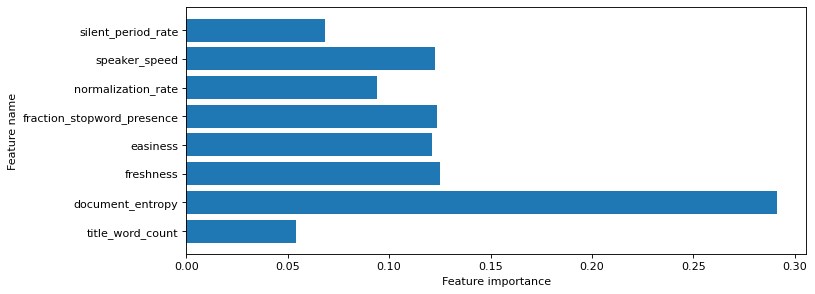

In [10]:
## Random Forest
randfor = RandomForestClassifier()
sqrt_features = int(sqrt(len(features)))
num_features_list = list(range(sqrt_features-1,sqrt_features+2,1))
grid_values = {'max_features':num_features_list, "n_estimators":[10,15,25,50,100,200]}
cv = 3
randfor_grid = GridSearchCV(randfor, param_grid=grid_values, scoring='roc_auc', cv=cv)
randfor_grid.fit(X_train, y_train)
y_val_scores_randfor_grid = randfor_grid.predict_proba(X_val)
y_val_scores_randfor_grid = y_val_scores_randfor_grid[:,1]
randfor_grid_fpr, randfor_grid_tpr, _ = roc_curve(y_val, y_val_scores_randfor_grid)
randfor_grid_roc_auc = auc(randfor_grid_fpr, randfor_grid_tpr)
print('Random Forest Grid best parameter (max. AUC): ', randfor_grid.best_params_)
# print('Random Forest Grid best score (AUC): ', randfor_grid.best_score_)
print('Random Forest Validation set AUC: ', roc_auc_score(y_val, y_val_scores_randfor_grid))
randfor = RandomForestClassifier(max_features=randfor_grid.best_params_['max_features'], n_estimators=randfor_grid.best_params_['n_estimators'])
randfor.fit(X_train, y_train)
randfor_fig = plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(randfor, features)
plt.show()

Random Forest Grid best parameter (max. AUC):  {'learning_rate': 0.1, 'max_depth': 5}
Gradient-Boosted Decision Trees Validation set AUC:  0.873926756171152


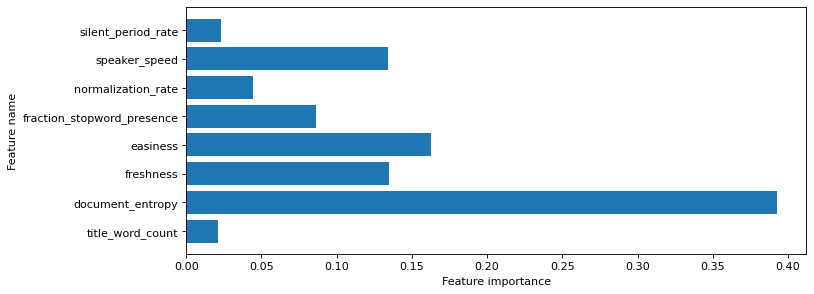

In [11]:
## Gradient Boosted Decision Trees
gbdt = GradientBoostingClassifier()
grid_values = {'learning_rate':[0.001,0.01,0.1], "max_depth":[2,3,4,5,100]}
cv = 3
gbdt_grid = GridSearchCV(gbdt, param_grid=grid_values, scoring='roc_auc', cv=cv)
gbdt_grid.fit(X_train, y_train)
y_val_scores_gbdt_grid = gbdt_grid.predict_proba(X_val)
y_val_scores_gbdt_grid = y_val_scores_gbdt_grid[:,1]
gbdt_grid_fpr, gbdt_grid_tpr, _ = roc_curve(y_val, y_val_scores_gbdt_grid)
gbdt_grid_roc_auc = auc(gbdt_grid_fpr, gbdt_grid_tpr)
print('Random Forest Grid best parameter (max. AUC): ', gbdt_grid.best_params_)
# print('Random Forest Grid best score (AUC): ', gbdt_grid.best_score_)
print('Gradient-Boosted Decision Trees Validation set AUC: ', roc_auc_score(y_val, y_val_scores_gbdt_grid))
gbdt = GradientBoostingClassifier(max_depth=gbdt_grid.best_params_['max_depth'], learning_rate=gbdt_grid.best_params_['learning_rate'])
gbdt.fit(X_train, y_train)
gbdt_fig = plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(gbdt, features)
plt.show()

In [13]:
def engagement_model():
    rec = None
    # YOUR CODE HERE
    # Input data, both training/validation and test sets
    trainval_df = pd.read_csv('assets/train.csv')
    test_df = pd.read_csv('assets/test.csv')
    # Break training/validation sets into targer and features
    trainval_y = trainval_df['engagement']
    trainval_X = trainval_df.loc[:, trainval_df.columns != 'engagement'].set_index('id')
    features = list(trainval_X.columns)
    X_test = test_df.set_index('id')
    X_test_ids = X_test.index.tolist()
    # Binarize the target values for the training and validation sets
    trainval_y = trainval_y.astype(str)
    trainval_y.replace(to_replace={'False':0,'True':1}, inplace=True)

    # Create training and validation sets for both features and targets
    X_train, X_val, y_train, y_val = train_test_split(trainval_X, trainval_y)

    # Define the scaler, then fit to X_train and transform X_train, X_val, and X_test
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    model_scores = {}
    
    ## Dummy Models
    # dummies = {}
    # for strategy in DummyClass_Strategies:
    #     dummies[strategy] = DummyClassifier(strategy=strategy).fit(X_train, y_train)
    # for key, dummy in dummies.items():
    #     print("Dummy Training Accuracy Score (Strategy = {})".format(key),dummy.score(X_train, y_train))
    #     print("Dummy Validation Accuracy Score (Strategy = {})".format(key),dummy.score(X_val, y_val))

    ## K-Nearest Neighbors with varying n
    best_mean = [0,0]
    n = 1
    for n in range(1,len(features)*2):
        knn = KNeighborsClassifier(n_neighbors = n)
        knn.fit(X_train, y_train)
        cv = 4
        knn_aucs = cross_val_score(knn, X_train, y_train, cv=cv, scoring="roc_auc")
        mean = np.mean(knn_aucs)
        if mean > best_mean[1]:
            best_mean[1] = mean
            best_mean[0] = n
    # print('KNN (n={}) Best mean cross-validation ROC AUC score ({}-fold) on Training Data: {:.3f}'.format(best_mean[0], cv, best_mean[1]))
    n = best_mean[0]
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    # print("Accuracy Score for KNN on Training Data (n={}):".format(n),knn.score(X_train, y_train))
    # print("Accuracy Score for KNN on Validation Data (n={}):".format(n),knn.score(X_val, y_val))
    y_val_scores_knn = knn.predict_proba(X_val)
    y_val_scores_knn = y_val_scores_knn[:,1]
    knn_fpr, knn_tpr, _ = roc_curve(y_val, y_val_scores_knn)
    knn_roc_auc = auc(knn_fpr, knn_tpr)
    print('KNN Validation set AUC: ', knn_roc_auc)
    model_scores['knn'] = (knn, knn_roc_auc)
    
    ## Linear Regression
    ## Polynomial Option
    # poly = PolynomialFeatures(degree=2)
    # X_train = poly.fit_transform(X_train)
    # X_val = poly.transform(X_val)
    # linreg = LinearRegression().fit(X_train, y_train)
    # linreg.fit(X_train, y_train)
    # cv = 3
    # linreg_aucs = cross_val_score(linreg, X_train, y_train, cv=cv, scoring="roc_auc")
    # print('LinReg Cross-validation scores ({}-fold):'.format(cv), linreg_aucs)
    # print('LinReg Mean cross-validation score ({}-fold): {:.3f}'.format(cv,np.mean(linreg_aucs)))
    # print("Accuracy Score for LinReg on Training Data:",linreg.score(X_train, y_train))
    # print("Accuracy Score for LinReg on Validation Data:",linreg.score(X_val, y_val))
       
    ## Linear Regression Ridge
    # linregridge = Ridge(alpha=0.1).fit(X_train, y_train)
    # print("Accuracy Score for RidgeReg on Training Data:",linregridge.score(X_train, y_train))
    # print("Accuracy Score for RidgeReg on Validation Data:",linregridge.score(X_val, y_val))
    ## Linear Ridge with GridSearchCV
    # linregridge = Ridge().fit(X_train, y_train)
    # grid_values = {'alpha': [0.01, 0.1, 1, 10, 100]}
    # cv = 2
    # linregridge_grid = GridSearchCV(linregridge, param_grid=grid_values, scoring='roc_auc', cv=cv)
    # linregridge_grid.fit(X_train, y_train)
    # print('LinRegRidge Grid best parameter (max. AUC): ', linregridge_grid.best_params_)
    # print('LinRegRidge Grid best score (AUC): ', linregridge_grid.best_score_)
    # linregridge = Ridge(alpha=linregridge_grid.best_params_['alpha'])
    
    ## Linear Regression Lasso
    # linreglasso = Lasso(alpha=0.1).fit(X_train, y_train)
    # print("Accuracy Score for LassoReg on Training Data:",linreglasso.score(X_train, y_train))
    # print("Accuracy Score for LassoReg on Validation Data:",linreglasso.score(X_val, y_val))
    ## Linear Lasso with GridSearchCV
    # linreglasso = Lasso().fit(X_train, y_train)
    # grid_values = {'alpha': [0.01, 0.1, 1, 10, 100]}
    # cv = 2
    # linreglasso_grid = GridSearchCV(linreglasso, param_grid=grid_values, scoring='roc_auc', cv=cv)
    # linreglasso_grid.fit(X_train, y_train)
    # print('LinRegLasso Grid best parameter (max. AUC): ', linreglasso_grid.best_params_)
    # print('LinRegLasso Grid best score (AUC): ', linreglasso_grid.best_score_)
    # linreglasso = Lasso(alpha=linreglasso_grid.best_params_['alpha'])
    
    ## Logisitc Regression, C=10
    # logreg = LogisticRegression(C=10).fit(X_train, y_train)
    # print("Accuracy Score on Training Set:",logreg.score(X_train, y_train))
    # print("Accuracy Score on Validation Set:",logreg.score(X_val, y_val))
    # y_val_scores = logreg.fit(X_train, y_train).decision_function(X_val)
    # logreg_fpr, logreg_tpr, _ = roc_curve(y_val, y_val_scores)
    # logreg_roc_auc = auc(logreg_fpr, logreg_tpr)
    # print("Logistic Regression ROC Curve AUC (C = {}):".format(C),logreg_roc_auc)
    ## Logisitc Regression & GridSearchCV and scoring on ROC AUC
    # logreg = LogisticRegression()
    # grid_values = {'C': [0.01, 0.1, 1, 10, 100]}
    # cv = 2
    # logreg_grid = GridSearchCV(logreg, param_grid=grid_values, scoring='roc_auc', cv=cv)
    # logreg_grid.fit(X_train, y_train)
    # y_val_scores_logreg_grid = logreg_grid.decision_function(X_val)
    # logreg_grid_fpr, logreg_grid_tpr, _ = roc_curve(y_val, y_val_scores_logreg_grid)
    # logreg_grid_roc_auc = auc(logreg_grid_fpr, logreg_grid_tpr)
    # print('LogReg Grid best parameter (max. AUC): ', logreg_grid.best_params_)
    # print('LogReg Grid best score (AUC): ', logreg_grid.best_score_)
    # print('LogReg Validation set AUC: ', roc_auc_score(y_val, y_val_scores_logreg_grid))
    # logreg = LogisticRegression(C=logreg_grid.best_params_['C'])
    
    ## Support Vector Machine with GridSearchCV
    svc = SVC(kernel='rbf')
    # grid_values = {'gamma': [0.01, 0.1, 1, 10, 100], 'C': [0.01, 0.1, 1, 10, 100]}
    grid_values = {'gamma': [0.1, 1, 10, 100], 'C': [0.1, 1, 10, 100]}
    cv = 3
    svc_grid = GridSearchCV(svc, param_grid=grid_values, scoring='roc_auc', cv=cv)
    svc_grid.fit(X_train, y_train)
    y_val_scores_svc_grid = svc_grid.decision_function(X_val)
    svc_grid_fpr, svc_grid_tpr, _ = roc_curve(y_val, y_val_scores_svc_grid)
    svc_grid_roc_auc = auc(svc_grid_fpr, svc_grid_tpr)
    # print('SVC Grid best parameter (max. AUC): ', svc_grid.best_params_)
    # print('SVC Grid best score (AUC): ', svc_grid.best_score_)
    print('SVC Validation set AUC: ', roc_auc_score(y_val, y_val_scores_svc_grid))
    svc = SVC(kernel='rbf', C=svc_grid.best_params_['C'], gamma=svc_grid.best_params_['gamma'])
    svc.fit(X_train, y_train)
    model_scores['svc'] = (svc, svc_grid_roc_auc)
    
    ## Decision Tree Classifier
    # tree = DecisionTreeClassifier().fit(X_train, y_train)
    # print("Accuracy Score for Decision Tree on Training Data:",tree.score(X_train, y_train))
    # print("Accuracy Score for Decision Tree on Validation Data:",tree.score(X_val, y_val))
    ## Decision Tree Classifier with GridSearchCV
    tree = DecisionTreeClassifier()
    grid_values = {'max_depth': [2, 3, 4, 5, 6]}
    cv = 3
    tree_grid = GridSearchCV(tree, param_grid=grid_values, scoring='roc_auc', cv=cv)
    tree_grid.fit(X_train, y_train)
    y_val_scores_tree_grid = tree_grid.predict_proba(X_val)
    y_val_scores_tree_grid = y_val_scores_tree_grid[:,1]
    tree_grid_fpr, tree_grid_tpr, _ = roc_curve(y_val, y_val_scores_tree_grid)
    tree_grid_roc_auc = auc(tree_grid_fpr, tree_grid_tpr)
    # print('Tree Grid best parameter (max. AUC): ', tree_grid.best_params_)
    # print('Tree Grid best score (AUC): ', tree_grid.best_score_)
    print('Tree Validation set AUC: ', roc_auc_score(y_val, y_val_scores_tree_grid))
    tree = DecisionTreeClassifier(max_depth=tree_grid.best_params_['max_depth'])
    tree.fit(X_train, y_train)
    model_scores['tree'] = (tree, tree_grid_roc_auc)
    
    ## Naive Bayes (Gaussian)
    nbg = GaussianNB().fit(X_train, y_train)
    y_val_scores_nbg = nbg.predict_proba(X_val)
    y_val_scores_nbg = y_val_scores_nbg[:,1]
    nbg_fpr, nbg_tpr, _ = roc_curve(y_val, y_val_scores_nbg)
    nbg_roc_auc = auc(nbg_fpr, nbg_tpr)
    print('Naive Bayes (Gaussian) Validation set AUC: ', nbg_roc_auc)
    model_scores['nbg'] = (nbg, nbg_roc_auc)
    
    ## Random Forest
    randfor = RandomForestClassifier()
    sqrt_features = int(sqrt(len(features)))
    num_features_list = list(range(sqrt_features-2,sqrt_features+2,1))
    grid_values = {'max_features':num_features_list, "n_estimators":[10,15,25,50,100,200]}
    cv = 3
    randfor_grid = GridSearchCV(randfor, param_grid=grid_values, scoring='roc_auc', cv=cv)
    randfor_grid.fit(X_train, y_train)
    y_val_scores_randfor_grid = randfor_grid.predict_proba(X_val)
    y_val_scores_randfor_grid = y_val_scores_randfor_grid[:,1]
    randfor_grid_fpr, randfor_grid_tpr, _ = roc_curve(y_val, y_val_scores_randfor_grid)
    randfor_grid_roc_auc = auc(randfor_grid_fpr, randfor_grid_tpr)
    print('Random Forest Grid best parameter (max. AUC): ', randfor_grid.best_params_)
    # print('Random Forest Grid best score (AUC): ', randfor_grid.best_score_)
    print('Random Forest Validation set AUC: ', roc_auc_score(y_val, y_val_scores_randfor_grid))
    randfor = RandomForestClassifier(max_features=randfor_grid.best_params_['max_features'], n_estimators=randfor_grid.best_params_['n_estimators'])
    randfor.fit(X_train, y_train)
    model_scores['randfor'] = (randfor, randfor_grid_roc_auc)
    
    ## Gradient Boosted Decision Trees
    gbdt = GradientBoostingClassifier()
    grid_values = {'learning_rate':[0.001,0.01,0.1], "max_depth":[2,3,4,5,100]}
    cv = 3
    gbdt_grid = GridSearchCV(gbdt, param_grid=grid_values, scoring='roc_auc', cv=cv)
    gbdt_grid.fit(X_train, y_train)
    y_val_scores_gbdt_grid = gbdt_grid.predict_proba(X_val)
    y_val_scores_gbdt_grid = y_val_scores_gbdt_grid[:,1]
    gbdt_grid_fpr, gbdt_grid_tpr, _ = roc_curve(y_val, y_val_scores_gbdt_grid)
    gbdt_grid_roc_auc = auc(gbdt_grid_fpr, gbdt_grid_tpr)
    print('Random Forest Grid best parameter (max. AUC): ', gbdt_grid.best_params_)
    # print('Random Forest Grid best score (AUC): ', gbdt_grid.best_score_)
    print('Gradient-Boosted Decision Trees Validation set AUC: ', roc_auc_score(y_val, y_val_scores_gbdt_grid))
    gbdt = GradientBoostingClassifier(max_depth=gbdt_grid.best_params_['max_depth'], learning_rate=gbdt_grid.best_params_['learning_rate'])
    gbdt.fit(X_train, y_train)
    model_scores['gbdt'] = (gbdt, gbdt_grid_roc_auc)
    
    ## MLP Classifier
    MLP = MLPClassifier()
    # nn = MLPClassifier(solver='lbfgs', activation = 'tanh', alpha = 0.1,
    #                    hidden_layer_sizes = [len(features)**2, len(features)]).fit(X_train, y_train)
    
    model_scores = sorted(model_scores.values(), key=lambda x:x[1], reverse=True)
    best_model = model_scores[0][0]
    predictions = best_model.predict_proba(X_test)
    predictions = predictions[:,1]
    return pd.Series(predictions,index=X_test_ids,name='engagement')
    
    raise NotImplementedError()
    
answer = engagement_model()
answer

SVC Validation set AUC:  0.8492305471098806
Tree Validation set AUC:  0.8519227829395478
Naive Bayes (Gaussian) Validation set AUC:  0.8202253155096564
Random Forest Grid best parameter (max. AUC):  {'max_features': 3, 'n_estimators': 100}
Random Forest Validation set AUC:  0.8714584784196491
Random Forest Grid best parameter (max. AUC):  {'learning_rate': 0.1, 'max_depth': 4}
Gradient-Boosted Decision Trees Validation set AUC:  0.8883698809301377


9240     0.008184
9241     0.035667
9242     0.089048
9243     0.977667
9244     0.009268
           ...   
11544    0.020335
11545    0.011086
11546    0.010711
11547    0.941957
11548    0.014962
Name: engagement, Length: 2309, dtype: float64

In [14]:
stu_ans = answer
assert isinstance(stu_ans, pd.Series), "Your function should return a pd.Series. "
assert len(stu_ans) == 2309, "Your series is of incorrect length: expected 2309 "
assert np.issubdtype(stu_ans.index.dtype, np.integer), "Your answer pd.Series should have an index of integer type representing video id."

In [ ]:
stu_ans = engagement_model()
assert isinstance(stu_ans, pd.Series), "Your function should return a pd.Series. "
assert len(stu_ans) == 2309, "Your series is of incorrect length: expected 2309 "
assert np.issubdtype(stu_ans.index.dtype, np.integer), "Your answer pd.Series should have an index of integer type representing video id."